#  Прогнозирование заказов такси

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-признаков" data-toc-modified-id="Подготовка-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка признаков</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Обучение моделей</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

**Описание**

Цель проекта:

Основная цель проекта - разработать модель машинного обучения, способную прогнозировать количество заказов такси на следующий час, основываясь на исторических данных. Это поможет компании "Чётенькое такси" более эффективно управлять ресурсами, в частности, привлекать больше водителей в периоды пиковой нагрузки. Ключевой показатель успеха проекта - достижение значения метрики RMSE (Root Mean Squared Error) не более 48 на тестовой выборке.

Описание задачи:

1.  Анализ временных рядов: Данные о заказах такси представляют собой временной ряд, поскольку они упорядочены во времени. Необходимо проанализировать структуру этого ряда, выявить тренды, сезонность и другие закономерности, которые могут повлиять на прогнозы.

2.  Прогнозирование: На основе анализа данных нужно построить модель, которая сможет предсказывать количество заказов такси на следующий час. Это задача прогнозирования временных рядов.

**Библиотеки и константы**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sklearn
import catboost
import lightgbm as lgb
import time
import os

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings("ignore")

In [2]:
RANDOM_STATE = 42

## Загрузка и подготовка данных

In [3]:
pth1 = 'taxi.csv'
pth2 = '/datasets/taxi.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1, index_col=[0], parse_dates=[0])
elif os.path.exists(pth2):
    df = pd.read_csv(pth2, index_col=[0], parse_dates=[0])
else:
    print('Something is wrong')
    
df.sort_index(inplace=True)

In [4]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
df.tail()

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


Загрузка данных прошла успешно. Мы имеем дело с временным рядом, где данные собраны с 10-минутным интервалом, а количество заказов (num_orders) выступает в качестве зависимой переменной.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Пропущенные значения отсутствуют. Тип данных, представляющих зависимую переменную, соответствует ожидаемому формату.

In [7]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Медиана наших данных равна 13, однако максимальное значение сильно выделяется и составляет 119. Похоже, что распределение данных имеет особенности, поэтому необходимо изучить его

In [8]:
def get_hist(df, column, bins):
    fig = plt.figure(figsize=(12, 8))
    grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)

    ax_main = fig.add_subplot(grid[:-1, :-1])
    ax_bottom = fig.add_subplot(grid[-1, 0:-1], xticklabels=[], yticklabels=[])

    ax_main.hist(df[column], bins=bins, edgecolor='black')
    sns.boxplot(x=df[column], ax=ax_bottom)
    ax_main.set(title='Распределение признака ' + column, ylabel='Количество наблюдений')
    plt.show()

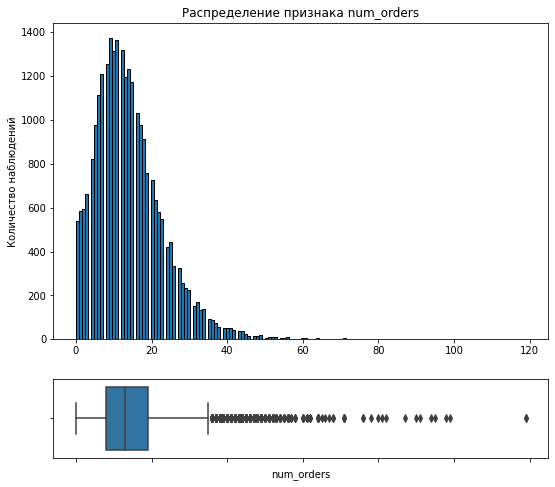

In [9]:
get_hist(df, 'num_orders', 150)

Боксплот показал наличие значений, выходящих за пределы межквартильного размаха. Давайте посмотрим на них внимательнее. Чтобы это сделать, выберем данные, превышающие 70, так как именно после этого значения данные становятся более редкими.

In [10]:
big_data = df[df['num_orders'] > 70]
big_data['dayofweek'] = big_data.index.dayofweek
big_data

,num_orders,dayofweek
datetime,,
2018-08-13 01:10:00,71,0
2018-08-13 02:10:00,78,0
2018-08-13 02:20:00,119,0
2018-08-13 02:30:00,99,0
2018-08-20 02:00:00,87,0
2018-08-20 02:10:00,90,0
2018-08-20 02:20:00,94,0
2018-08-20 02:30:00,82,0
2018-08-20 02:40:00,80,0


Я предлагаю сохранить эти данные, поскольку они потенциально содержат ценную информацию о пиковых нагрузках на сервис. Предварительный анализ указывает, что эти пики чаще всего наблюдаются в ночь с воскресенья на понедельник и могут быть обусловлены такими факторами, как проведение мероприятий, задержки авиарейсов или недостаток такси у конкурирующих компаний.

Произведем ресемплирование данных, используя часовой интервал

In [11]:
df = df.resample('1H').sum()

## Анализ

In [12]:
def get_plot(df, title):
    plt.figure(figsize=(16, 6))

    plt.plot(df, label='Заказы такси')
    plt.fill_between(df.index, 0, df.values, alpha=0.05)

    plt.title(title)
    plt.xlabel('Время')
    plt.ylabel('Количество заказов')

    plt.legend()

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.box(False)

    plt.show()

In [13]:
decomposed = seasonal_decompose(df)

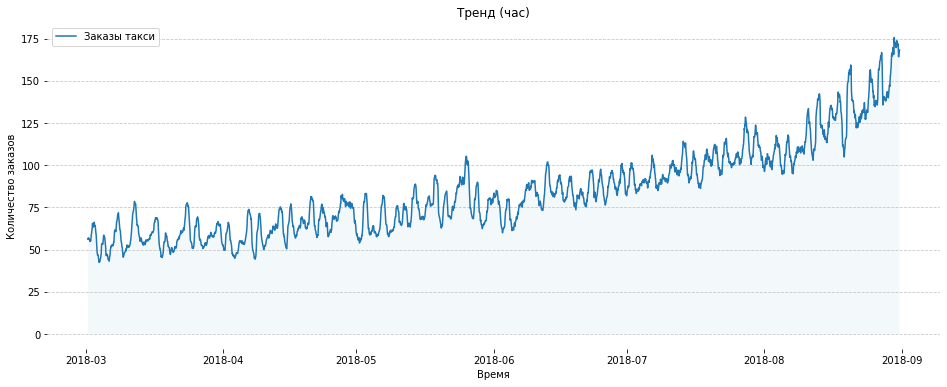

In [14]:
get_plot(decomposed.trend, 'Тренд (час)')

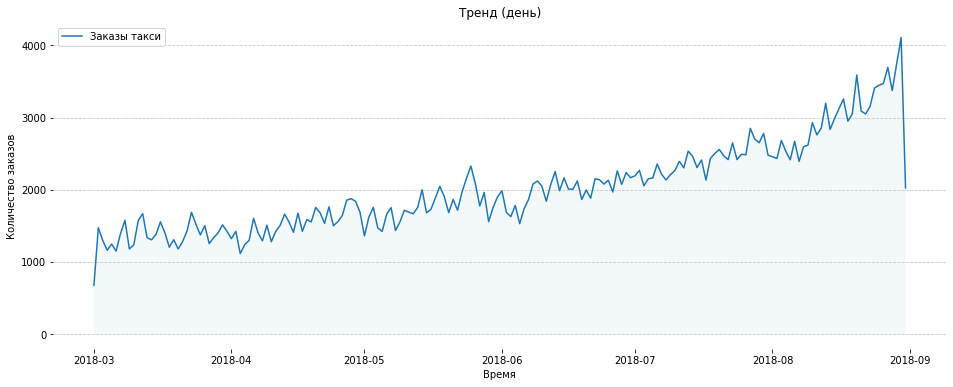

In [15]:
get_plot(decomposed.trend.resample('1D').sum(), 'Тренд (день)')

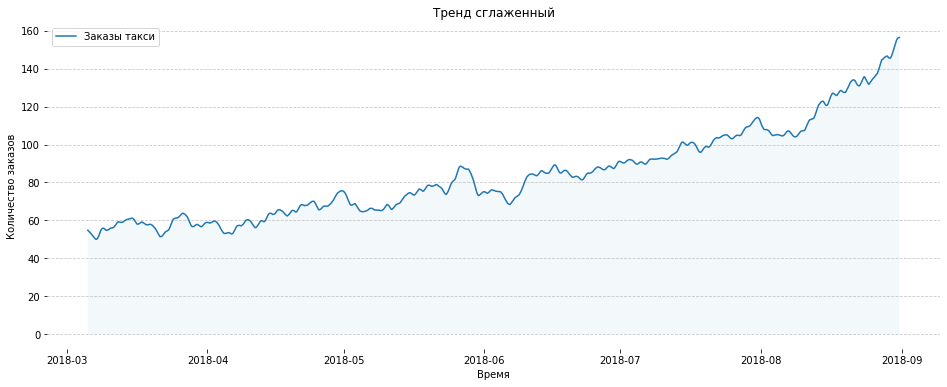

In [16]:
get_plot(decomposed.trend.rolling(100).mean(), 'Тренд сглаженный')

Наблюдается тенденция к увеличению спроса на услуги такси в течение последних шести месяцев, если рассматривать почасовые данные.

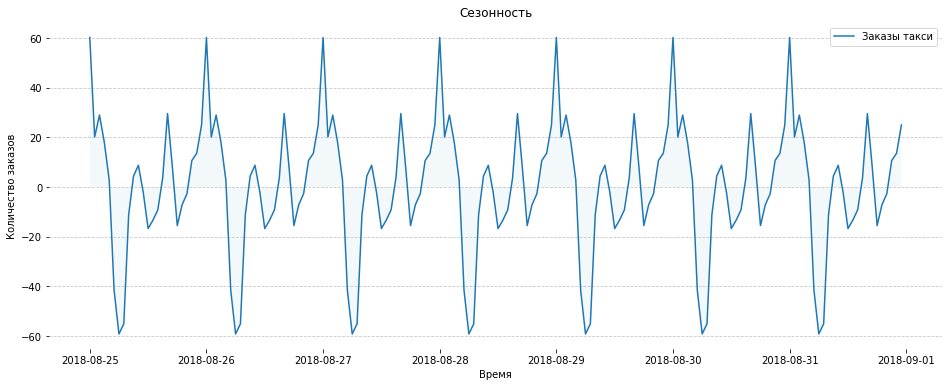

In [17]:
get_plot(decomposed.seasonal.tail(24*7), 'Сезонность')

Суточный спрос имеет сезонную структуру: минимальные значения приходятся на ночь, максимальные — на вечер, с дополнительным локальным пиком во второй половине дня.

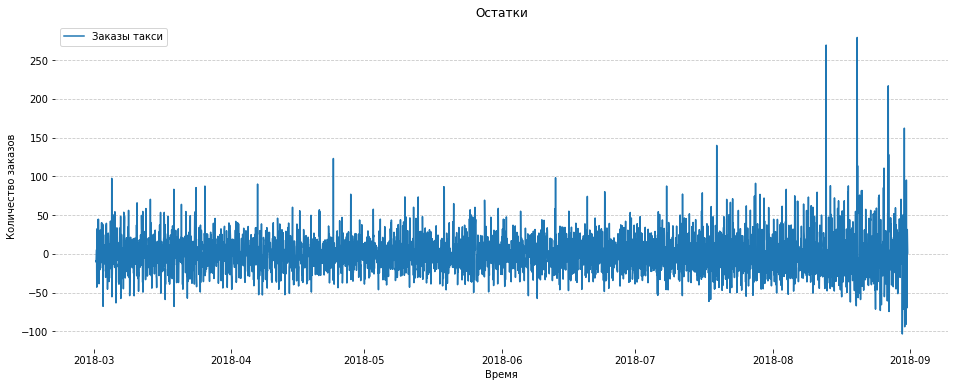

In [18]:
get_plot(decomposed.resid, 'Остатки')

Остатки выглядят как белый шум, то есть они случайны и не имеют явных закономерностей. значит, модель хорошо уловила тренд и сезонность

## Обучение

### Подготовка признаков

Для обогащения наших данных мы разработаем функцию make_features, которая будет принимать DataFrame (df), максимальный лаг (max_lag) и размер окна для скользящего среднего (rolling_mean_size). Эта функция добавит в DataFrame новые признаки, такие как год, месяц, день, день недели, а также признаки, основанные на сдвиге данных и скользящем среднем.

In [19]:
def make_features(df, max_lag, rolling_mean_size):
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

In [20]:
make_features(df, 7, 1)
df.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
datetime,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,124.0
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,85.0
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,71.0
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,66.0


Text(0.5, 1.0, 'Распределение признака month')

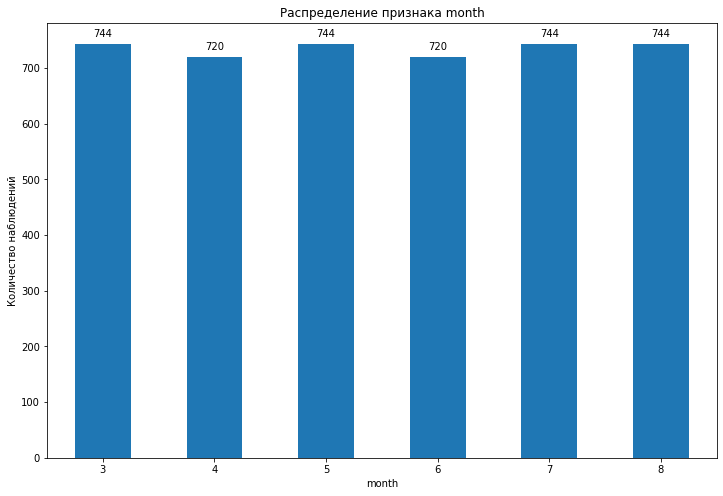

In [21]:
pivot_table = df.pivot_table(index='month', 
                             aggfunc='size')
ax = pivot_table.plot(kind='bar', figsize=(12, 8))
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.ylabel('Количество наблюдений')
plt.title('Распределение признака month')

In [22]:
print(f'До удаления: {df.shape}')
df = df.drop('month', axis=1)
print(f'После удаления: {df.shape}')

До удаления: (4416, 13)
После удаления: (4416, 12)


Для обеспечения корректной оценки моделей машинного обучения, предлагается разделить имеющиеся данные на три части: обучающую выборку (80%), валидационную выборку (10%) и тестовую выборку (10%). Валидационная выборка будет использоваться для подбора оптимальной модели, которая впоследствии будет оценена на тестовой выборке

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('num_orders', axis=1),
                                                                df['num_orders'],
                                                                test_size=0.1,
                                                                shuffle=False,
                                                                random_state=RANDOM_STATE)

In [24]:
pd.DataFrame({
    'Выборка':['X_train', 'y_train',
               'X_test', 'y_test'],
    
    'Размер выборки':[X_train.shape, y_train.shape,
                      X_test.shape, y_test.shape]
})

,Выборка,Размер выборки
0,X_train,"(3974, 11)"
1,y_train,"(3974,)"
2,X_test,"(442, 11)"
3,y_test,"(442,)"


### Обучение моделей

Мы проведем обучение трех моделей машинного обучения, последовательно увеличивая их сложность: DecisionTreeRegressor, RandomForestRegressor и LGBMRegressor. Для каждой модели будет выполнен подбор оптимальных гиперпараметров. Затем мы измерим время обучения, время предсказания и значение RMSE на валидационной выборке. В заключение, мы выберем модель, показавшую лучшие результаты.

In [25]:
models = [
    DecisionTreeRegressor(random_state=RANDOM_STATE),
    RandomForestRegressor(random_state=RANDOM_STATE),
    LGBMRegressor(random_state=RANDOM_STATE)
]

models_parameters = [
    [
        'DecisionTreeRegressor', 
        {'min_samples_leaf': range(1, 11),
        'max_depth': range(1, 11)} 
    ],
    [
        'RandomForestRegressor',
        {'max_depth': range(5, 10),
        'n_estimators': [100, 150]} 
    ],
    [
        'LGBMRegressor', 
        {'max_depth': range(2, 11),
        'learning_rate': [0.01, 0.05, 0.1]} 
    ]
]

In [26]:
%%time
models_df = {}

splits = TimeSeriesSplit(n_splits=3)

for i in range(3):
    rs = RandomizedSearchCV(
    models[i],
    models_parameters[i][1],
    n_jobs=-1,
    cv=splits,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE
    )

    start_fit = time.time()
    rs.fit(X_train, y_train)
    end_fit = time.time()
    fit_time = round(end_fit - start_fit, 4)
    
    start_predict = time.time()
    rs.predict(X_test)
    end_predict = time.time()
    predict_time = round(end_predict - start_predict, 4)

    if i == 0:
        models_df['model'] = [models_parameters[i][0]]
        models_df['parameters'] = [rs.best_params_]
        models_df['training_time(ms)'] = [fit_time]
        models_df['predict_time(ms)'] = [predict_time]
        models_df['cross_valid_score(RMSE)'] = [round(rs.best_score_ * -1, 2)]

    else:
        models_df['model'].append(models_parameters[i][0])
        models_df['parameters'].append(rs.best_params_)
        models_df['training_time(ms)'].append(fit_time)
        models_df['predict_time(ms)'].append(predict_time)
        models_df['cross_valid_score(RMSE)'].append(round(rs.best_score_ * -1, 2))

pd.DataFrame(models_df)

CPU times: user 54.4 s, sys: 783 ms, total: 55.2 s
Wall time: 55.7 s


,model,parameters,training_time(ms),predict_time(ms),cross_valid_score(RMSE)
0,DecisionTreeRegressor,"{'min_samples_leaf': 4, 'max_depth': 9}",0.4404,0.0020,31.63
1,RandomForestRegressor,"{'n_estimators': 150, 'max_depth': 9}",31.9818,0.0200,28.57
2,LGBMRegressor,"{'max_depth': 10, 'learning_rate': 0.05}",23.2359,0.0028,27.60


LGBMRegressor является лучшей моделью. Вот почему:

1.  Наименьший RMSE на валидационной выборке: LGBMRegressor показал наименьшую ошибку на кросс-валидации (27.60), что является ключевым показателем точности модели.
2.  Баланс между скоростью и точностью:  Хотя DecisionTreeRegressor обучается и предсказывает быстрее, его точность значительно хуже. RandomForestRegressor показывает хорошую точность, но тратит больше времени. LGBMRegressor находит оптимальный баланс между скоростью и точностью, имея достаточно малое время обучения и предсказания, а также лучшую точность.

Следует также отметить, что, несмотря на свою простоту, модель DecisionTreeRegressor показала результаты, сопоставимые с более сложными моделями, при этом демонстрируя наивысшую скорость работы. 

Отсутствие переобучения наблюдается во всех трех рассмотренных моделях.

**LGBMRegressor**

In [27]:
final_model_lgbm = LGBMRegressor(max_depth=10,
                                 learning_rate=0.05,
                                 random_state=RANDOM_STATE)
final_model_lgbm.fit(X_train, y_train)

LGBMRegressor(learning_rate=0.05, max_depth=10, random_state=42)

## Тестирование

In [28]:
print("LGBMRegressor:", np.sqrt(mean_squared_error(y_test,
                                                    final_model_lgbm.predict(X_test))))

LGBMRegressor: 46.32013659565132


Значение метрики RMSE на тестовой выборке меньше 48

Проанализируем распределение и дисперсию остатков модели

In [29]:
result = y_test.to_frame().reset_index()
result['pred'] = pd.Series(final_model_lgbm.predict(X_test))
result.set_index('datetime', inplace=True)

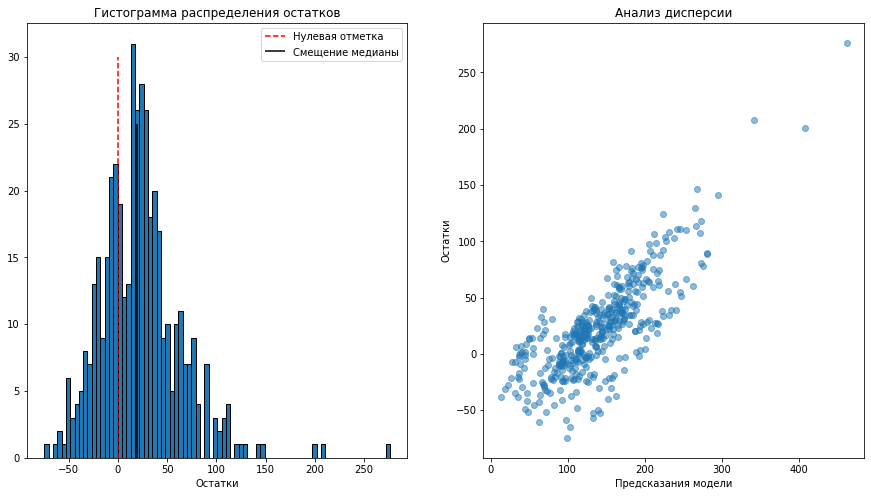

In [30]:
residuals = result['num_orders'] - result['pred']
    
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
axes[0].hist(residuals, bins=80, edgecolor='black')
zero = axes[0].vlines(x=0, colors='red', ymin=0, ymax=30, linestyles='--', label='Нулевая отметка')
median = axes[0].vlines(x=residuals.median(), colors='black', ymin=0, ymax=25, label='Смещение медианы')
axes[0].legend()
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(result['num_orders'], residuals, alpha=0.5)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

Распределение остатков модели приближается к нормальному, что является благоприятным признаком. Наблюдается незначительное смещение медианы остатков в положительную сторону. Анализ дисперсии остатков показывает, что для предсказаний до 150 заказов дисперсия остается относительно случайной, в то время как при значениях более 150 наблюдается тенденция к увеличению ошибки в положительную сторону. Это указывает на то, что модель имеет тенденцию занижать предсказания для высоких значений тестовой выборки.

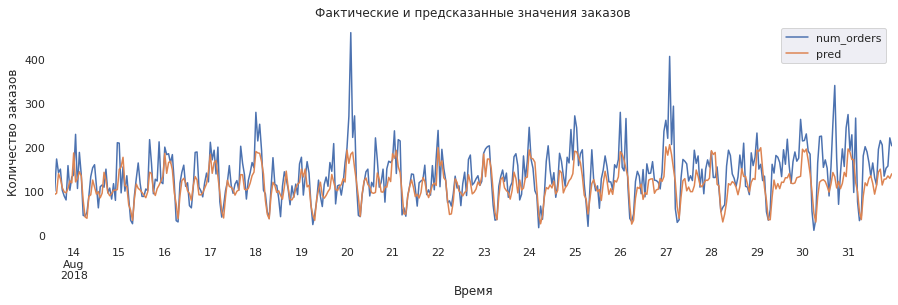

In [31]:
sns.set(rc={'figure.figsize':(15,4)})
result.plot()
plt.title('Фактические и предсказанные значения заказов')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.legend()

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.box(False)

plt.show()

Наблюдается, что модель смогла уловить временные паттерны в спросе. Вместе с тем, мы вновь сталкиваемся с тем, что модель систематически занижает прогнозы для больших значений теста.

Рекомендации по улучшению модели:

* Введение дополнительных признаков, специфичных для высоких значений: Можно попробовать добавить признаки, которые могут быть связаны с высоким спросом, например, наличие праздников, акций, особых дней недели и т.д. Это позволит модели учитывать контекст, когда спрос обычно выше.
* Более тщательный подбор гиперпараметров: Провести более широкий поиск гиперпараметров. 